## Studi Kasus

Pada studi kasus ini kita akan mencoba membuat sistem biometrik mengggunakan modalitas sinyal EEG. Sinyal EEG yang digunakan meruapak data primer yang direkam dengan menggunakan Emotiv Insight. Terdapat 2 subyek yang berpartisipasi pada proses perekaman. Setiap subyek melakukan 5 kali perekaman (trial) pada kondisi mata terbuka (*eye open*). Setiap perekaman terdiri dari 2 sesi. Sesi pertama adalah tahap pengkondisian (40 detik), sesi kedua adalah tahap perekaman kondisi pada kondisi releks dengan mata terbuka (80 detik). Total data yang akan digunakan adalah 10 data.  Sampling rate yang perekaman sinyal EEG adalah 128Hz. Dataset direkam dalam bentuk CSV, dan tidak ada proses anotasi selama perekaman.

## Proses Pengolahan Data

Secara umum, proses pengolahan data dibagi menjadi beberapa tahapan, yaitu,

1. Pembersihan data
2. Pra pengolahan data
3. Pengolahan data
4. Klasifikasi

In [84]:
# Import kebutuhan library

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Kebutuhan ekstraksi band
from scipy.signal import butter, filtfilt

# Kebutuhan ekstransi fitur
from sklearn.decomposition import FastICA
from scipy.signal import welch

# Kebutuhan klasifiaksi
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV, RepeatedKFold
import joblib

### Pembersihan data

Pada tahap ini, kita akan melakukan modifikasi terhadap data yang kita miliki. Sebelumnya, kita akan melakukan inspeksi manual terlebih dahulu terhadap data yang kita miliki. Berdasarkan hasil inspeksi, terdapat beberapa hal yang harus kita lakukan, diantaranya,

1. Membuat header data yang tidak perlu
2. Membuang kolom yang tidak perlu
3. Mengubah format waktu ke UTC+7 (WIB)
4. Membuat kolom baru untuk menyimpan informasi waktu (detik)

In [4]:
# Fungsi ini digunakan untuk membersihkan data yang tidak perlu
# serta memodifikasi data, khususnya bagian timestamp

def inspect_data(data):
    '''
        Drop specific data from Emotiv Insight CSV

        Parameters:
            data (file)     : CSV file from Emotiv Insight format
        
        Returns:
            df (DataFrame)  : EEG data
            pkg_drop (bool) : Check package drop from EEG data
            cq_mean (float) : Mean of contact quality of sensor
    '''
    # Baca data dan simpan dalam obyek pandas DataFrame
    # Kita lewati baris pertama karena terdapat header yang tidak perlu dan tidak sesuai kolom dibawahnya
    df = pd.read_csv(data, skiprows=[0])
    
    # Definisikan kolom yang tidak digunakan dalam bentuk list
    drop_cols = ['EEG.RawCq', 'EEG.Battery', 'EEG.BatteryPercent', 'MarkerIndex', 'MarkerType', 'MarkerValueInt', 'EEG.MarkerHardware', 'EQ.SampleRateQuality', 'EQ.OVERALL', 'EQ.AF3', 'EQ.T7', 'EQ.Pz', 'EQ.T8', 'EQ.AF4', 'MOT.CounterMems', 'MOT.InterpolatedMems', 'MOT.Q0', 'MOT.Q1', 'MOT.Q2', 'MOT.Q3', 'MOT.AccX', 'MOT.AccY', 'MOT.AccZ', 'MOT.MagX', 'MOT.MagY', 'MOT.MagZ']

    # Hapus kolom yang tidak digunakan
    df.drop(columns=drop_cols, inplace=True)
    
    # Convert Timestamp ke UTC+7 (WIB)
    df["Timestamp"] = pd.to_datetime(df["Timestamp"], unit='s')
    df["Timestamp"] = df["Timestamp"].dt.tz_localize('UTC').dt.tz_convert('Asia/Jakarta').dt.tz_localize(None)
    
    # Membuat kolom baru "Sec" untuk menyimpan data detik keberapa berdasarkan data timestamp
    df["Sec"] = df["Timestamp"].astype(str)
    df["Sec"] = df["Sec"].str.rsplit(pat=":").str[2]
    
    # Pindah posisi kolom 'Sec' ke kolom ke-2
    reorder = [x for x in range(14)]
    reorder.insert(1, -1)
    df = df[df.columns[reorder]]

    # Kita return obyek DataFrame
    return df

In [6]:
# Contoh pembersihan data untuk data S11
s11 = inspect_data("eeg_raw/S11.csv")

# Cek DataFrame
s11.head()

,Timestamp,Sec,EEG.Counter,EEG.Interpolated,EEG.AF3,EEG.T7,EEG.Pz,EEG.T8,EEG.AF4,CQ.AF3,CQ.T7,CQ.Pz,CQ.T8,CQ.AF4,CQ.Overall
0,2021-04-14 12:34:09.482873856,09.482873856,1.0,0.0,4251.282227,4232.820313,4233.846191,4158.974121,4239.487305,4.0,4.0,4.0,4.0,4.0,100.0
1,2021-04-14 12:34:09.490597888,09.490597888,2.0,0.0,4254.358887,4240.512695,4248.717773,4163.077148,4235.384766,4.0,4.0,4.0,4.0,4.0,100.0
2,2021-04-14 12:34:09.498420992,09.498420992,3.0,0.0,4255.897461,4248.205078,4255.897461,4172.820313,4240.000000,4.0,4.0,4.0,4.0,4.0,100.0
3,2021-04-14 12:34:09.506243840,09.506243840,4.0,0.0,4252.820313,4244.102539,4251.794922,4173.333496,4244.615234,4.0,4.0,4.0,4.0,4.0,100.0
4,2021-04-14 12:34:09.514067968,09.514067968,5.0,0.0,4251.794922,4240.512695,4248.717773,4172.820313,4243.077148,4.0,4.0,4.0,4.0,4.0,100.0


In [8]:
# Kita lakukan untuk semua subyek dan semua trial
# manualy :))

s12 = inspect_data("eeg_raw/S12.csv")
s13 = inspect_data("eeg_raw/S13.csv")
s14 = inspect_data("eeg_raw/S14.csv")
s15 = inspect_data("eeg_raw/S15.csv")

s31 = inspect_data("eeg_raw/S31.csv")
s32 = inspect_data("eeg_raw/S32.csv")
s33 = inspect_data("eeg_raw/S33.csv")
s34 = inspect_data("eeg_raw/S34.csv")
s35 = inspect_data("eeg_raw/S35.csv")

### Pra Pengolahan Data

Setelah data telah dibersihkan, kita akan masuk pada proses pra pengolahan data. Pada tahap ini terdapat beberapa hal yang kita lakukan, yaitu,

1. Memotong data. Data pada tahap pengkondisian tidak akan kita gunakan. Kemudian, kita hanya akan menggunakan data selama 60 detik setelah tahap pengkondisian.
2. Normalisasi data untuk setiap kanal (sensor). Normalisasi dilakukan untuk mendapatkan rentang nilai antara -1 hingga 1.
3. Membuang sinyal *electrooculogram* (EOG) dengan menggunakan **Fast Independend Component Analysis** (FastICA)
4. Sinyal akan disegmentasi (epoch) sepanjang 5 detik untuk setiap kanal (*channel*)

In [9]:
# Fungsi untuk memotong data yang tidak perlu

def cutoff(data, baseline = 5119, duration = 60, sampling = 128):
    '''
        Cutoff data into certain duration.

        Params:
            data (DataFrame) : EEG data
            baseline (int)   : start cutoff, we remove the first 60s of data. Sampling rate 128Hz. Default = 7680
            duration (int)   : duration of EEG data. Default = 60
            sampling (int)   : Used sampling rate. Default = 128
        
        Returns:
            eeg (ndarray) : numpy array (n_channel, n_data) consist of AF3, AF4, T7, T8, Pz
    '''
    dur = (duration * sampling)
    cut = data[baseline:baseline+dur]
    
    # Mengambil data hanya dari sensor EEG
    eeg = np.array([
        cut["EEG.AF3"].values,
        cut["EEG.AF4"].values,
        cut["EEG.T7"].values,
        cut["EEG.T8"].values,
        cut["EEG.Pz"].values
        
        
    ])

    # Return dalam bentuk numpy ndarray
    return eeg

In [11]:
# Contoh pemotongan data untuk S11
s11_cut = cutoff(s11)

# Cek hasil pemotongan
print(s11_cut)

# Cek dimensi data
# Seharusnya 5x7680 -> 5 kanal x (60 detik x 128Hz)
print(s11_cut.shape)

[[4243.589844 4248.717773 4253.846191 ... 4413.333496 4407.692383
  4402.05127 ]
 [4220.512695 4227.179688 4229.743652 ... 4368.205078 4368.205078
  4370.769043]
 [4248.205078 4265.128418 4274.871582 ... 4364.102539 4361.538574
  4350.256348]
 [4199.487305 4210.769043 4204.102539 ... 4260.512695 4261.538574
  4260.      ]
 [4156.410156 4175.384766 4177.436035 ... 4288.205078 4293.333496
  4292.820313]]
(5, 7680)


In [12]:
# Kita lakukan untuk semua subyek dan semua trial
# manualy :))

s12_cut = cutoff(s12)
s13_cut = cutoff(s13)
s14_cut = cutoff(s14)
s15_cut = cutoff(s15)

s31_cut = cutoff(s31)
s32_cut = cutoff(s32)
s33_cut = cutoff(s33)
s34_cut = cutoff(s34)
s35_cut = cutoff(s35)

In [13]:
# Langkah selanjutnya adalah normalisasi. 
# 2 fungsi ini akan membantu kita dalam proses normalisasi

# Normalisasi hanya untuk 1 kanal / 1 array
def normalize(x):
    '''
        Normalize signal into max amplitudo 1 and min amplitudo -1

        Parameters:
            x (float, ndarray)  : EEG signal
        
        Returns:
            xnorm (float, array-like)   : Normalized EEG signal
    '''
    xmin = min(x)
    xmax = max(x)
    maxamp = 0
    xnorm = 0

    if (abs(xmax) >= abs(xmin)):
        maxamp = abs(xmax)
    else:
        maxamp = abs(xmin)
    
    if (xmin == xmax):
        return 'Cannot normalize the signal.'
    else:
        xnorm = x / maxamp
        return xnorm

# Fungsi untuk normaliasi semua kanal dengan looping
def normalize_eeg(data, channel_num = 5):
    '''
        Normalized eeg data from (n_channel, n_data) array-like format

        Params:
            data (float 2darray)    : EEG data
            channel_num             : Number of channel(s)
        
        Return:
            eeg_norm (foat 2darray) : normalize eeg signal with max amp 1 and min amp -1
    '''

    eeg_norm = []
    for i in range(channel_num):
        s = normalize(data[i])
        s.transpose()
        s = list(s)
        eeg_norm.append(s)
    
    return np.asarray(eeg_norm)

Text(63.0, 0.5, 'Normalized Amplitude')

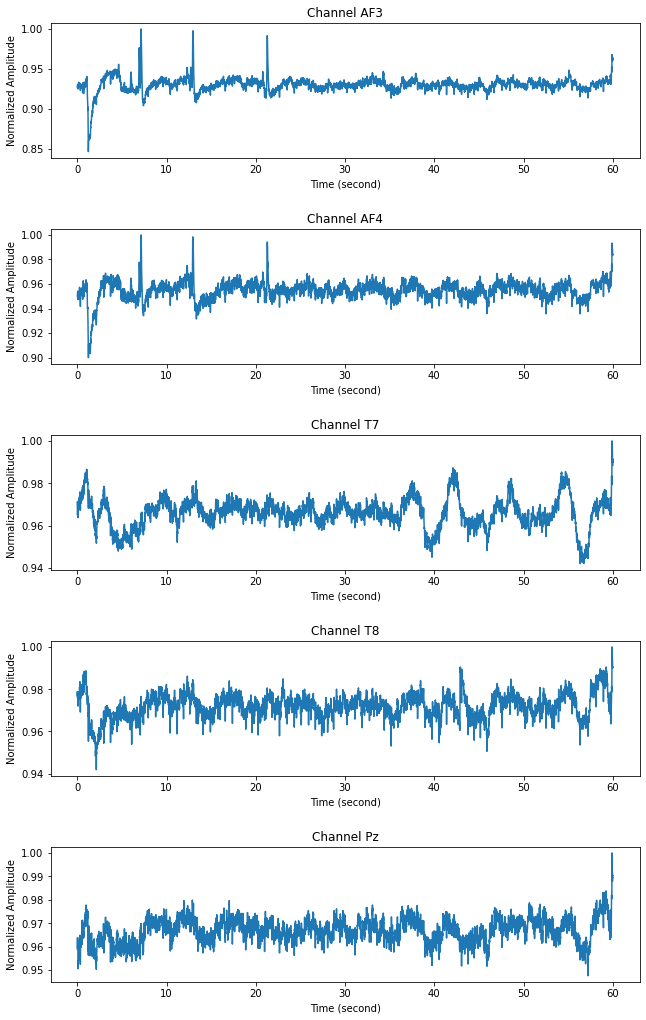

In [15]:
# Contoh normaliasi untuk S11
s11n = normalize_eeg(s11_cut)

# Cek hasil normalisasi dengan ploting data

# Definisikan plot dengan 5 subplot
fig, axs = plt.subplots(5, figsize=(10,15))
plt.tight_layout(pad=5.0)

# Mendefinisikan time untuk x-axis
times = np.arange(len(s11n[0]))/128

# Plot AF3
axs[0].plot(times,s11n[0])
axs[0].set_title('Channel AF3')
axs[0].set_xlabel('Time (second)')
axs[0].set_ylabel('Normalized Amplitude')

# Plot AF4
axs[1].plot(times,s11n[1])
axs[1].set_title('Channel AF4')
axs[1].set_xlabel('Time (second)')
axs[1].set_ylabel('Normalized Amplitude')

# Plot T7
axs[2].plot(times,s11n[2])
axs[2].set_title('Channel T7')
axs[2].set_xlabel('Time (second)')
axs[2].set_ylabel('Normalized Amplitude')

# Plot T8
axs[3].plot(times,s11n[3])
axs[3].set_title('Channel T8')
axs[3].set_xlabel('Time (second)')
axs[3].set_ylabel('Normalized Amplitude')

# Plot Pz
axs[4].plot(times,s11n[4])
axs[4].set_title('Channel Pz')
axs[4].set_xlabel('Time (second)')
axs[4].set_ylabel('Normalized Amplitude')

In [27]:
# Kita normaliasi untuk semua subyek
# Manualy :))
s12n = normalize_eeg(s12_cut)
s13n = normalize_eeg(s13_cut)
s14n = normalize_eeg(s14_cut)
s15n = normalize_eeg(s15_cut)

s31n = normalize_eeg(s32_cut)
s32n = normalize_eeg(s32_cut)
s33n = normalize_eeg(s33_cut)
s34n = normalize_eeg(s34_cut)
s35n = normalize_eeg(s35_cut)

In [16]:
# Langkah selanjutnya adalah melakukan pemisahan sinyal EOG.
# Sinyal EOG adalah sinyal yang terekam akibat aktivitas kedipan mata.
# Sinyal ini dapat tercampur dengan sinyal EEG dikarenakan kita menggunakan kanal AF3 dan AF4,
# yang lokasinya sangat dekat dengan mata.

# Salah satu cara untuk memisahkan sinyal tersebut, kita data menggunakan metode FastICA.
# FastICA akan mendekompoisisi sinyal menjadi beberapa komponen.
# Dari sini, kita dapat mengetahui dekomposisi sinyal mana yang kita curigai sebagai sinyal EEG.
# Jika di visualisasikan, biasanya, sinyal EOG akan menunjukkan derajat yang tinggi pada bagian depan
# kepala manusia.
# Fungsi yang akan kita gunakan adalah FastICA() dari package sklearn.decomposition.

# Catatan Penting:
# Sayangnya, teknik ini harus dilakukan secara manual untuk setiap data (subyek).
# Hal ini dikarenakan setiap subyek memiliki kareteristik yang berbeda, dan hasil dekomposisi dapat berbeda pula.
# Namun, pada kasus ini, untuk mempermudah pembelajaran, kita akan menggunakan komponen yang sama untuk setiap subyek.

# Cek komponen EOG dengan FastICA
def get_ica_comps(data, comp = 5, max_iter = 200, random_state = 0, tol = 0.05):
    '''
        Extract ICA Components

        Params:
            data (float, ndarray)   : EEG signal
            random_state (int)      : random state control
            tol (float)             : tolerance update each iteration
            max_iter (int)          : maximum iteration
        
        Returns:
            eeg_clean (float, ndarray) : clean eeg signal in data x channel shape
            ica (object)               : FastICA object
    '''

    # Transpose data ke data x channel karena fungsi FastICA.fit_transform() meminta demikian
    data = data.transpose()
    
    # Mendefinisikan fungsi FastICA dengan konfigurasi yang kita gunakan dan simpan dalam obyek
    ica = FastICA(n_components=5, random_state= random_state, tol = tol)
    
    # Transform data sinyal ke komponen ICA
    comps = ica.fit_transform(data)

    # Return dalam bentuk tuple berisi komponen dan obyek FastICA
    return comps, ica

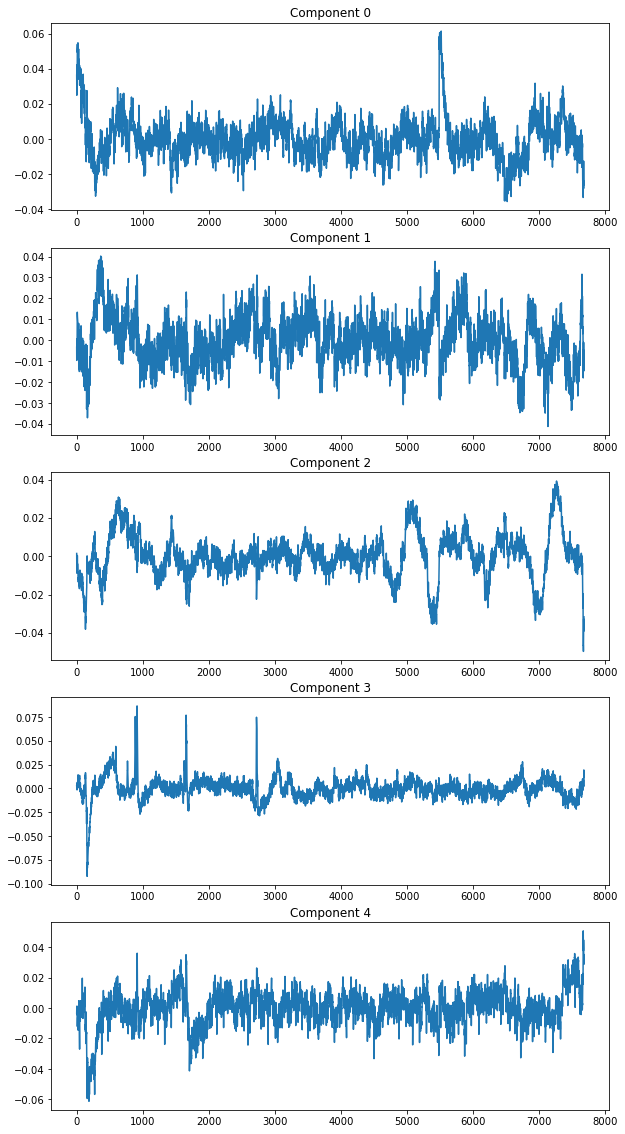

In [24]:
# Contoh untuk S11
s11_ica, ica = get_ica_comps(s11n)

# Kita akan cek komponen EOG dengan FastICA dengan melakukan ploting komponen
# Fungsi bantuan untuk ploting komponen ICA
def plot_eeg(data, sub_title, sub_numbs):
    '''
        Helper for plotting EEG data

        Params:
            data (float, ndarray)   : EEG data in channel x data
            sub_title (str)         : Sub Title
    '''
    fig, axs = plt.subplots(sub_numbs, figsize=(10,20))

    for i in range(sub_numbs):
        axs[i].plot(data[i])
        axs[i].set_title(f'{sub_title} {i}')

# Plot komponen
plot_eeg(s11_ica.transpose(), 'Component', 5) # Data perlu ditranspose ulang ke kanal x data

In [25]:
# Pada studi kasus ini, kita akan mencurigai komponen 4 sebagai sinyal EOG,
# maka, kita akan membuang komponen tersebut dan merekonstruksi ulang sinyal EEG

# Fungsi bantuan untuk melakukan rekonstruksi sinyal EEG
def comps_restored(ica_comps, comps, init_ica):
    '''
        Remove selected ICA component (EOG) then reconstruct the signal

        Params:
            ica_comps (float, ndarray)  : ICA components
            comps (int or int list)     : Selected component to be removed
            init_ica (object)           : ICA object. Should be aleready initailized
        
        Returns:
            restored (float, ndarray)   : Reconstructed data after ICA component removal. Shape data x channel
    '''
    reconstruct = ica_comps.copy()
    reconstruct[:, comps] = 0
    restored = init_ica.inverse_transform(reconstruct)

    return restored

(7680, 5)


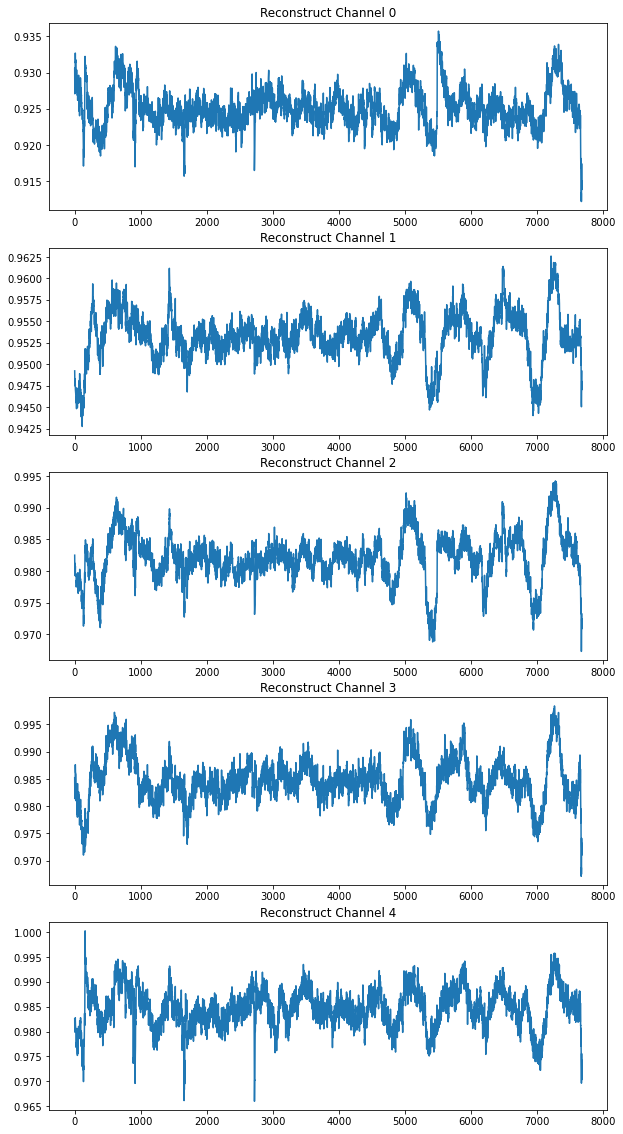

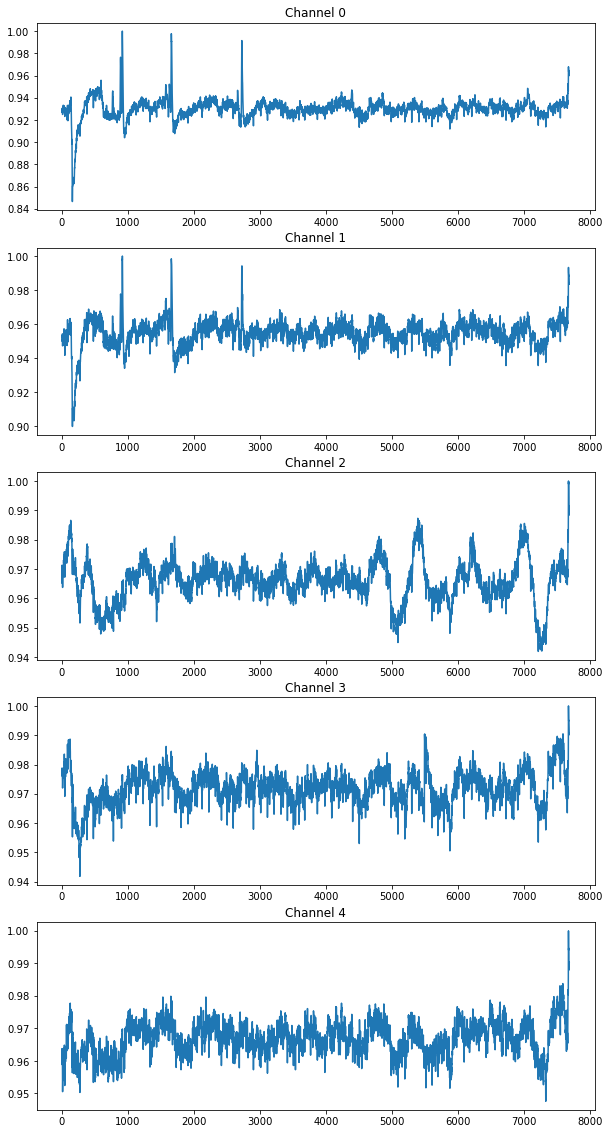

In [31]:
# Contoh rekonstruksi sinyal EEG untuk S11
s11_restored = comps_restored(s11_ica, [4], ica)

# Cek dimensi sinyal EEG yang telah direkonstruksi
print(s11_restored.shape)

# Plot sinyal EEG yang telah direkonstruksi dibandingkan dengan sinyal EEG asli
plot_eeg(s11_restored.transpose(), 'Reconstruct Channel', 5)
plot_eeg(s11n, 'Channel', 5)

In [32]:
# Kita lakukan lagi untuk semua subyek
# manually :))

# Subyek 1
s12_ica, ica = get_ica_comps(s12n) # dekomposisi ICA, obyek ica dapat digunakan berkali kali untuk sinyal lainnya
s12_restored = comps_restored(s12_ica, [4], ica) # rekonstruksi sinyal EEG

s13_ica, _ = get_ica_comps(s13n)
s13_restored = comps_restored(s13_ica, [4], ica)

s14_ica, _ = get_ica_comps(s14n)
s14_restored = comps_restored(s14_ica, [4], ica)

s15_ica, _ = get_ica_comps(s15n)
s15_restored = comps_restored(s15_ica, [4], ica)

# Subyek 3
s31_ica, _ = get_ica_comps(s31n)
s31_restored = comps_restored(s31_ica, [4], ica)

s32_ica, _ = get_ica_comps(s32n)
s32_restored = comps_restored(s32_ica, [4], ica)

s33_ica, _ = get_ica_comps(s33n)
s33_restored = comps_restored(s33_ica, [4], ica)

s34_ica, _ = get_ica_comps(s34n)
s34_restored = comps_restored(s34_ica, [4], ica)

s35_ica, _ = get_ica_comps(s35n)
s35_restored = comps_restored(s35_ica, [4], ica)

In [29]:
# Langkah terakhir dalam proses pra pengolahan data adalah segmentasi (epoch).
# Segmentasi adalah proses pengambilan data yang dibatasi dengan batasan waktu.
# Sinyal akan kita segmentasi menjadi setiap 5 detik untuk semua kanal.

# Fungsi bantuan untuk segmentasi
def segmented_data(data, seg_length = 5, sampling = 128):
    '''
        Construct data into segments

        Params:
            data (float, ndarray)   : EEG data. Shape (n_channel, n_data)
            seg_length (int)        : Segment length in seconds. Default = 5
            sampling (int)          : Sampling rate. Default = 128
        
        Returns
            eeg_segments (float, ndarray)   : Segmented EEG signal (n_channel, n_segment, n_data)
    '''

    data = np.transpose(data) # transpose data ke kanal x data
    ch = data.shape[0] # cek jumlah kanal
    cut = seg_length * sampling # panjang segment = 5 detik * 128 sampling rate = 640 data poin
    length = data.shape[1] - cut
    data = list(data)
    eeg_segments = []

    for i in range(ch):
        segs = []
        d = data[i]
        for j in range(0, length+1, cut):
            tmp = d[j:j+cut]
            segs.append(tmp)

        eeg_segments.append(segs)
    
    # Hasil return adalah numpy ndarray dengan bentuk (n_channel, n_segment, n_data) -> (5, 12, 640)
    return np.asarray(eeg_segments)

In [30]:
# Contoh untuk S11
s11_segs = segmented_data(s11_restored)

# Cek dimensi data
s11_segs.shape

(5, 12, 640)

In [33]:
# Kita lakukan hal yang sama untuk semua subyek
s11_segs = segmented_data(s11_restored)
s12_segs = segmented_data(s12_restored)
s13_segs = segmented_data(s13_restored)
s14_segs = segmented_data(s14_restored)
s15_segs = segmented_data(s15_restored)

s31_segs = segmented_data(s31_restored)
s32_segs = segmented_data(s32_restored)
s33_segs = segmented_data(s33_restored)
s34_segs = segmented_data(s34_restored)
s35_segs = segmented_data(s35_restored)

### Pengolahan Data

Pada pengolahan data, kita akan melakukan 2 hal utama, yaitu,

1. Ektraksi band. Gelombang yang akan kita gunakan adalah, delta (1-4Hz), tetha (4-8Hz), alpha (8-14Hz), beta (14-30Hz), dan gamma (30-50Hz). Gelombang ini didapatkan dengan menggunakan metode bandpass filter Butterworth.
2. Ektransi fitur. Fitur yang akan digunakan adalah *Power Spectral Density* (PSD).
3. Memilih segmen (epoch). Dari semua segmen (epoch) yang telah kita buat, kita hanya akan menggunakan segmen (epoch) ke-2.
4. *Flatten*. Mengubah data fitur yang sebelumnya multidimensi menjadi 1D.

In [35]:
# Langkah pertama dalam pengolahan data adalah ekstraksi band
# Kita akan menggunakan filter Butterworth dan menggunakan rentang frekuensi yang sudah kita tentukan.




# Membuat desain / mendefinisikan filter IIR Butterworth
def butter_bandpass(lowcut, highcut, fs, order=3):
    '''
        Butterworth filter designer

        Params:
            lowcut (int)      : highpass filter frequency in Hz
            highcut (int)     : lowpass filter frequency in Hz
            fs (int)          : Sampling rate
            order             : Butterworth order

        Returns:
            b, a (ndarray, ndarry)  : Numerator (b) and denominator (a) polynomials of the IIR filter
    '''

    nyq = 0.5 * fs # nyquist frequency
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='bandpass')

    return b, a

# Fungsi bantuan untuk mengimplementasikan Buttworth filter untuk ekstraksi band
def butter_bandpass_filter(data, lowcut, highcut, fs, order=3):
    '''
        Butterworth bandpass filter

        Params:
            data (float, ndarray)       : The signal
            lowcut (int)                : Highpass filter in hz
            highcut (int)               : Lowpass filter in hz
            fs (int)                    : The signal sampling rate
            order (int)                 : Butterworth order. Default = 3

        Returns:
            filtered (float, ndarray)          : Filtered signal
    '''

    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    filtered = filtfilt(b, a, data)

    return filtered

# Fungsi bantuan untuk melakukan ektrasi band untuk semua data
def bandpass_filter_segments(data, fs=128, order=3):
    '''
        Extact bands (d,t,a,b,g) using Butterworth bandpass filter

        Params:
            data (float, ndarray)       : EEG segmented data. Dim (n_channel, n_segment, n_data)
            lowcut (int)                : Highpass filter in Hz
            highcut (int)               : Lowpass filter in Hz
            fs (int)                    : Sampling rate. Default 128
            order (int)                 : Butterworth order. Default 3
    '''

    ch_nums = data.shape[0]
    seg_nums = data.shape[1]
    seg_length = data.shape[2]

    ch_bands = np.empty((0, seg_nums, 5, seg_length)) # membuat empty array untuk menampung hasil ekstraksi band

    for i in range(ch_nums):
        segs_band = np.empty((0, 5, seg_length))
        
        for j in range(seg_nums):
            bands = None
            d = butter_bandpass_filter(data[i][j], 1, 4, fs=fs, order=order) # delta 1-4 Hz
            t = butter_bandpass_filter(data[i][j], 4, 8, fs=fs, order=order) # tetha 4-8 Hz
            a = butter_bandpass_filter(data[i][j], 8, 14, fs=fs, order=order) # alpha 8-14 Hz
            b = butter_bandpass_filter(data[i][j], 14, 30, fs=fs, order=order) # beta 14-30 Hz
            g = butter_bandpass_filter(data[i][j], 30, 50, fs=fs, order=order) # gamma 30-50 Hz
            bands = np.array([d, t, a, b, g])
            segs_band = np.append(segs_band, [bands], axis=0)
        
        ch_bands = np.append(ch_bands, [segs_band], axis=0)
    
    # Return dalam bentuk (n_channel, n_segment, n_band, n_data)
    return ch_bands

(5, 12, 5, 640)


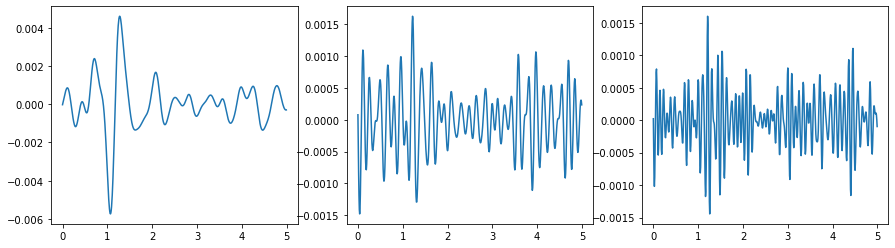

In [37]:
# Contoh untuk S11
s11_bands = bandpass_filter_segments(s11_segs, fs=128, order=3)

# Cek dimensi data
print(s11_bands.shape)

# Buat rentang waktu untuk ploting di x-axis
times = np.arange(640)/128

# Cek ekstraksi band untuk untuk cek hasilnya
plt.figure(figsize=(15,4))
plt.subplot(131)
plt.plot(times, s11_bands[0][0][0]) # delta seg 1
plt.subplot(132)
plt.plot(times, s11_bands[0][0][1]) # tetha seg 1
plt.subplot(133)
plt.plot(times, s11_bands[0][0][2]) # alpha seg 1

In [38]:
# Kita lakukan hal yang sama untuk semua subyek
s12_bands = bandpass_filter_segments(s12_segs, fs=128, order=3)
s13_bands = bandpass_filter_segments(s13_segs, fs=128, order=3)
s14_bands = bandpass_filter_segments(s14_segs, fs=128, order=3)
s15_bands = bandpass_filter_segments(s15_segs, fs=128, order=3)

s31_bands = bandpass_filter_segments(s31_segs, fs=128, order=3)
s32_bands = bandpass_filter_segments(s32_segs, fs=128, order=3)
s33_bands = bandpass_filter_segments(s33_segs, fs=128, order=3)
s34_bands = bandpass_filter_segments(s34_segs, fs=128, order=3)
s35_bands = bandpass_filter_segments(s35_segs, fs=128, order=3)

In [39]:
# Langkah selanjutnya adalah melakukan ekstraksi fitur.
# Fitur yang akan kita gunakan adalah PSD.

# Fungsi bantuan untuk mengimplementasikan PSD
def feature_psd(data, window, fs=128, nperseg=1, noverlap=None, nfft=None):
    '''
        Extract PSD (power spectral density) features from each band

        Params:
            data (float, ndarray)       : EEG data
            fs (int)                    : EEG data sampling rate. Default 128
            window (str)                : Sliding window type. Default 'hann'
            nperseg (int, optional)     : Length of each segment in seconds
            noverlap (int, optional)    : Number of points to overlap between segments in seconds
            nfft (int, optional)        : Length of fft window
        
        Returns:
            f (ndarray)                 : Sample frequency
            psd (ndarray)               : power spectral densitiy of EEG data
    '''
    nperseg = nperseg * fs
    noverlap = noverlap * fs if noverlap is not None else None
    nfft = nfft if nfft is not None else None

    f, psd = welch(data, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap, nfft=nfft)

    # Return nilai sample frequkensi dan PSD itu sendiri dalam bentuk tuple
    return f, psd

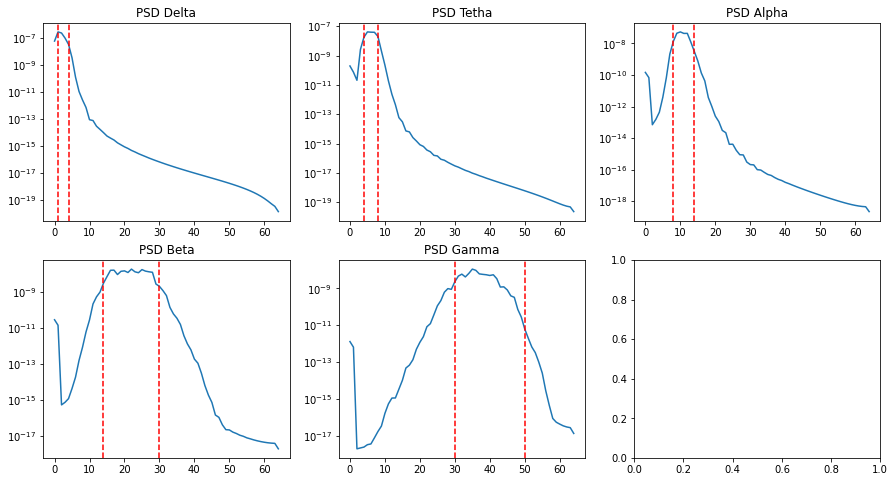

In [42]:
# Kita cek untuk contoh S11 kanal AF3, segmen ke-6
f_d, psd_d = feature_psd(s11_bands[0][5][0], window='hann', fs=128, nperseg=1, noverlap=0.5) #d
f_t, psd_t = feature_psd(s11_bands[0][5][1], window='hann', fs=128, nperseg=1, noverlap=0.5) #t
f_a, psd_a = feature_psd(s11_bands[0][5][2], window='hann', fs=128, nperseg=1, noverlap=0.5) #a
f_b, psd_b = feature_psd(s11_bands[0][5][3], window='hann', fs=128, nperseg=1, noverlap=0.5) #b
f_g, psd_g = feature_psd(s11_bands[0][5][4], window='hann', fs=128, nperseg=1, noverlap=0.5) #g


fig, axs = plt.subplots(2,3, figsize=(15,8))

axs[0,0].semilogy(f_d, psd_d)
axs[0,0].set_title('PSD Delta')
axs[0,0].axvline(x=1, color='red', ls='--')
axs[0,0].axvline(x=4, color='red', ls='--')
axs[0,1].semilogy(f_t, psd_t)
axs[0,1].set_title('PSD Tetha')
axs[0,1].axvline(x=4, color='red', ls='--')
axs[0,1].axvline(x=8, color='red', ls='--')
axs[0,2].semilogy(f_a, psd_a)
axs[0,2].set_title('PSD Alpha')
axs[0,2].axvline(x=8, color='red', ls='--')
axs[0,2].axvline(x=14, color='red', ls='--')
axs[1,0].semilogy(f_b, psd_b)
axs[1,0].set_title('PSD Beta')
axs[1,0].axvline(x=14, color='red', ls='--')
axs[1,0].axvline(x=30, color='red', ls='--')
axs[1,1].semilogy(f_g, psd_g)
axs[1,1].set_title('PSD Gamma')
axs[1,1].axvline(x=30, color='red', ls='--')
axs[1,1].axvline(x=50, color='red', ls='--')

In [43]:
# Fungsi bantuan untuk ekstraksi fitur PSD untuk semua data
def feature_psd_segments(data, window='hann', fs=128, nperseg=1, noverlap=None, nfft=None):
    '''
        Extract psd feature for each segments and each bands

        Params:
            data (float, ndarray)       : EEG data. Dimension (n_channel, n_segment, n_bands, n_data)
            window (str)                : Sliding window for PSD Welch. Default hanning window or 'hann'
            fs (int)                    : Sampling rate
            nperseg (int, optional)     : Length of each segment in seconds
            noverlap (int, optional)    : Number of points to overlap between segments in seconds
            nfft (int, optional)        : Length of fft window
        
        Returns

    '''
    # cek panjang data PSD
    _ , psd_length = feature_psd(data[0][0][0], window='hann', fs=fs, nperseg=nperseg, noverlap=noverlap, nfft=nfft) 
    
    # Simpan panjang data untuk patokan membuat penampungan data
    psd_length = len(psd_length)
    
    data_psd = data.copy()
    ch_nums = data.shape[0]
    seg_nums = data.shape[1]
    bands_nums = data.shape[2]

    # Membuat penampungan fitur PSD
    ch_psd = np.empty((0, seg_nums, bands_nums, psd_length))

    for i in range(ch_nums):
        segs_psd = np.empty((0, bands_nums, psd_length))
        for j in range(seg_nums):
            psd = None
            _, psd_d = feature_psd(data_psd[i][j][0], window='hann', fs=fs, nperseg=nperseg, noverlap=noverlap, nfft=nfft) # delta
            _, psd_t = feature_psd(data_psd[i][j][1], window='hann', fs=fs, nperseg=nperseg, noverlap=noverlap, nfft=nfft) # tetha
            _, psd_a = feature_psd(data_psd[i][j][2], window='hann', fs=fs, nperseg=nperseg, noverlap=noverlap, nfft=nfft) # alpha
            _, psd_b = feature_psd(data_psd[i][j][3], window='hann', fs=fs, nperseg=nperseg, noverlap=noverlap, nfft=nfft) # beta
            _, psd_g = feature_psd(data_psd[i][j][4], window='hann', fs=fs, nperseg=nperseg, noverlap=noverlap, nfft=nfft) # gamma
            
            psd = np.array([psd_d, psd_t, psd_a, psd_b, psd_g])
            segs_psd = np.append(segs_psd, [psd], axis=0)
        
        ch_psd = np.append(ch_psd, [segs_psd], axis=0)
    
    return ch_psd

In [45]:
# Ektraksi fitur PSD untuk semua data

s11_psd = feature_psd_segments(s11_bands, window='hann', fs=128, nperseg=1, noverlap=0.5)
s12_psd = feature_psd_segments(s12_bands, window='hann', fs=128, nperseg=1, noverlap=0.5)
s13_psd = feature_psd_segments(s13_bands, window='hann', fs=128, nperseg=1, noverlap=0.5)
s14_psd = feature_psd_segments(s14_bands, window='hann', fs=128, nperseg=1, noverlap=0.5)
s15_psd = feature_psd_segments(s15_bands, window='hann', fs=128, nperseg=1, noverlap=0.5)

s31_psd = feature_psd_segments(s31_bands, window='hann', fs=128, nperseg=1, noverlap=0.5)
s32_psd = feature_psd_segments(s32_bands, window='hann', fs=128, nperseg=1, noverlap=0.5)
s33_psd = feature_psd_segments(s33_bands, window='hann', fs=128, nperseg=1, noverlap=0.5)
s34_psd = feature_psd_segments(s34_bands, window='hann', fs=128, nperseg=1, noverlap=0.5)
s35_psd = feature_psd_segments(s35_bands, window='hann', fs=128, nperseg=1, noverlap=0.5)

# Cek dimensi data PSD
s35_psd.shape

(5, 12, 5, 65)

In [65]:
# Langkah selanjutnya adalah flatten.
# Flatten adalah proses untuk mengubah data menjadi 1 dimensi.

# Fungsi untuk flatten sekaligus memberikan label untuk data
def flatten_features(data, label):
    '''
        Flatten multidimensional feature vector

        Params:
            data(float, ndarray)        : EEG feature vector in (n_channel, n_segments, n_bands, n_feature)

        Returns
            flat (ndarray)              : Flatten feature vector
    '''
    flat = data.flatten()
    
    # Ubah ke list untuk memudahan menambahkan label
    flat = flat.tolist()
    flat.append(label)

    # Return numpy array
    return np.array(flat)

In [67]:
# Kita lakukan flatten untuk semua data

s11_flat = flatten_features(s11_psd, 'S1')
s12_flat = flatten_features(s12_psd, 'S1')
s13_flat = flatten_features(s13_psd, 'S1')
s14_flat = flatten_features(s14_psd, 'S1')
s15_flat = flatten_features(s15_psd, 'S1')

s31_flat = flatten_features(s31_psd, 'S3')
s32_flat = flatten_features(s32_psd, 'S3')
s33_flat = flatten_features(s33_psd, 'S3')
s34_flat = flatten_features(s34_psd, 'S3')
s35_flat = flatten_features(s35_psd, 'S3')

# Cek data
print(s11_flat)

# Cek dimensi data
print(s11_flat.shape)

<class 'numpy.ndarray'>
(19501,)


In [79]:
# Kombinasikan semua data menjadi 1.
combine = np.array([s11_flat, s12_flat, s13_flat, s14_flat, s15_flat, s31_flat, s32_flat, s33_flat, s34_flat, s35_flat])
combine.shape 

(10, 19501)

In [80]:
# Selanjutnya, kita akan membuat DataFrame untuk menyimpan data.
# DataFrame ini akan sangat membantu untuk proses klasifikasi.

# Fungsi untuk membuat DataFrame
def generate_df(data):
    '''
        Create header for dataset

        Params:
            data (ndarray like)     : Flatten feature
        
        Return
            df (DataFrame)          : Data frame with header
    '''

    cols = [f'Features {i}' for i in range(data.shape[1]-1)]
    label = 'Class'
    cols.append(label)

    # Generate data frame
    df = pd.DataFrame(data, columns=cols)

    return df

In [81]:
# Buat DataFrame
feature_df = generate_df(combine)

# Cek DataFrame
feature_df.head()

,Features 0,Features 1,Features 2,Features 3,Features 4,Features 5,Features 6,Features 7,Features 8,Features 9,...,Features 19491,Features 19492,Features 19493,Features 19494,Features 19495,Features 19496,Features 19497,Features 19498,Features 19499,Class
0,1.468808561444038e-07,8.438240782552737e-07,8.842654909804056e-07,2.5671253245445446e-07,7.701195300243075e-08,7.642072654411161e-09,2.7386578761588253e-10,1.3297050552048248e-11,3.4845072325342943e-12,6.679815783553272e-13,...,7.904144734540469e-15,6.235010303212417e-16,3.32749442400876e-16,2.0408518826897077e-16,1.1962303449543338e-16,8.360161391819682e-17,6.293962253588492e-17,5.272958097503644e-17,2.4782276521257972e-17,S1
1,3.4871647477372125e-08,1.4947165224274843e-07,1.4773822347131614e-07,1.40960021179288e-07,7.096527164007306e-08,1.1819175120395848e-08,1.3441815696966496e-10,2.357097670315402e-11,3.84071353622762e-12,7.700398381618246e-13,...,3.778542543019763e-15,8.835887598400537e-16,1.5384388041300704e-16,1.3413492936567534e-16,9.150321360857856e-17,7.127901911567826e-17,6.052358348482446e-17,5.458533038796938e-17,2.6356070851750693e-17,S1
2,5.977008074704326e-08,4.5006737816134667e-07,5.718073765268505e-07,2.419598798372452e-07,5.211434871629864e-08,4.807458442496827e-09,1.8869180351407875e-10,3.664182934355047e-11,2.7131644770053765e-12,4.593610124991026e-13,...,6.540069490628166e-15,1.1052472520844652e-15,4.873553218660865e-16,3.334077024187604e-16,2.6229793688720735e-16,2.1080244627461302e-16,1.8246602234214165e-16,1.6664079851962218e-16,8.083822771446084e-17,S1
3,1.0283145412525567e-07,4.6967202296798303e-07,3.536157604211238e-07,1.0781824054734138e-07,3.452084940949591e-08,4.803270610808807e-09,3.7997856608500416e-10,9.553955183510535e-12,9.762908084233227e-13,6.6669414464199e-13,...,4.871694743564828e-15,5.508312798096361e-16,1.42630002534623e-16,7.224150756828285e-17,5.623877042899516e-17,4.331731487198696e-17,3.5415356273050074e-17,3.130625293849735e-17,1.5010013203419914e-17,S1
4,1.1873690038325008e-07,5.285375706975537e-07,4.893015751160014e-07,1.9440066056995696e-07,5.365812467431774e-08,4.136100001556429e-09,2.7102586206766265e-10,3.2825316772455896e-11,6.876301318596258e-12,1.2298449156197613e-12,...,1.3810231561734938e-14,1.9119385242704105e-15,7.891822962644047e-16,4.3437427498930173e-16,2.43614451519966e-16,1.850107354931291e-16,1.4962758488506984e-16,1.304664953382538e-16,6.225229716470808e-17,S1


### Klasifikasi

Langkah terakhir, kita akan melakukan proses klasifikasi. Pada tahap ini kita akan menggunakan bantuan sklearn Pipeline untuk mempermudah proses manipulasi fitur. Manipulasi yang akan kita lakukan adalah,

1. Normalisasi nilai fitur menjadi rentang 0-1
2. Reduksi dimensi dengan menggunakan **Linear Discriminan Analysis (LDA)**
3. Encoding label menjadi angka dengan fungsi **LabelEncoding()** dari sklearn.
4. Klasifikasi dengan algoritma SVM menggunakan kernel linier.

Selain itu, kita akan menggunakan *cross validation* berulang untuk mendapatkan model terbaik. Fungsi yang dapat membantu kita untuk melakukan *cross validation* berulang adalah **RepeatedKFold()**. Selain itu, kita akan menggunakan fungsi **GridSearchCV()** untuk mengetahui mendapatkan *fold* yang terbaik sebagai model yang dihasilkan.

In [82]:
# Fungsi untuk klasifikasi
def build_model(data, model_path, encode_path):
    
    # Split features and labels
    features = data.iloc[:,:-1] # ambil hanya fitur dari DataFrame
    labels = data.iloc[:,-1] # ambil hanya label dari DataFrame
    encode = LabelEncoder() # definisikan LabelEncoder
    labels = encode.fit_transform(labels.astype('str')) # encode label menjadi angka
    

    # Build model
    scaler = MinMaxScaler()
    step = [
        ('scaler', scaler),
        ('reduce', LinearDiscriminantAnalysis()),
        ('model', SVC())
    ]

    params = {
        'model__kernel': ['linear'],
        'model__probability': [True]
    }

    cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=1)
    pipe = Pipeline(steps=step)
    grid = GridSearchCV(pipe, params, cv=cv).fit(features, labels)
    score = grid.score(features, labels)

    # Create a model file
    joblib.dump(grid, model_path) # simpan model untuk kebutuhan testing
    
    # Create an encoder file
    joblib.dump(encode, encode_path) # simpang encoding label untuk kebutuhan testing

    return score

In [85]:
# Cek hasil klasifikasi
build_model(feature_df, 'model.pkl', 'encoder.pkl')

0.9

In [99]:
# Coba kita prediksi dengan data S15

# Load model dan encoder
load_model = joblib.load('model.pkl')
load_encode = joblib.load('encoder.pkl')

s15 = feature_df.iloc[4,:-1].to_numpy() # ambil data S15, data ke-4 dari DataFrame
pred = load_model.predict((s15,)) # load flatten feature dan hanya ambil fitur saja
label = label = load_encode.inverse_transform(pred) # cek label dengan melakukan inverse encoding ke label string
print(f'Prediksi subyek adalah {label[0]}')

Prediksi subyek adalah S1
